<a href="https://colab.research.google.com/github/pachterlab/COVID-19-testing-database/blob/master/notebooks/basic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
!wget --output-file="logs.csv" "https://docs.google.com/spreadsheets/d/10I8bVkLzvrmXJsb5N-8JSFpWw5vBwDKYzyOVAI4viKo/export?format=csv&gid=1514440859" -O "sheet.csv"

In [272]:
!awk 'NR>4' sheet.csv > data.csv

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [274]:
df = pd.read_csv("data.csv")
df.index = df.institution.values
top_states = df.groupby("state").count().institution.sort_values(ascending=False).head(5).index.values


In [245]:
top_states

array(['CA', 'NY', 'PA', 'TX', 'MA'], dtype=object)

# Basic stats

In [247]:
df.groupby(["school_type", "test_initial", "test_recurring"])["testing"].count().sort_values()


school_type  test_initial  test_recurring
Private      FALSE         Unknown             2
             Unknown       TRUE                2
                           FALSE               3
Public       FALSE         Unknown             4
                           TRUE                5
             TRUE          Unknown             5
Private      FALSE         TRUE                6
Public       TRUE          FALSE               9
Private      TRUE          Unknown            12
                           FALSE              15
Public       TRUE          TRUE               16
             Unknown       Unknown            21
Private      Unknown       Unknown            25
             TRUE          TRUE               60
             FALSE         FALSE             119
Public       FALSE         FALSE             161
Name: testing, dtype: int64

In [248]:
pd.DataFrame(df.test_vendor.value_counts()).head(10)

,test_vendor
Broad Institute,19
Student Health,5
Vault Health,2
Student Health Services,2
LabCorp,2
University Health Center,2
unlisted,2
In house lab,2
Quest,2
arah Bush Lincoln Medical System,1


In [ ]:
# confusion matrix, testing initial vs testing recurring
v = df.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum()*100

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,60.085837,2.360515,1.287554
TRUE,5.150215,16.523605,3.648069
Unknown,0.643777,0.429185,9.871245


In [ ]:
# Testing based on school type
v = df.groupby(['school_type', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
school_type,,,
Public,43.946188,49.775785,6.278027
Private,32.377049,54.918033,12.704918


In [ ]:
v = df.groupby(['rtc_model', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)

v/v.values.sum(axis=1)[:,None]*100

testing,FALSE,TRUE,Unknown
rtc_model,,,
Planning for in-person,45.669291,46.850394,7.480315
Proposing a hybrid model,24.260355,64.497041,11.242604
Planning for online,52.777778,30.555556,16.666667
Considering a range of scenarios,25.000000,50.000000,25.000000
"All classes online, but many students will live on campus",0.000000,100.000000,0.000000
Proposing a hybrid model (all students on campus),0.000000,100.000000,0.000000


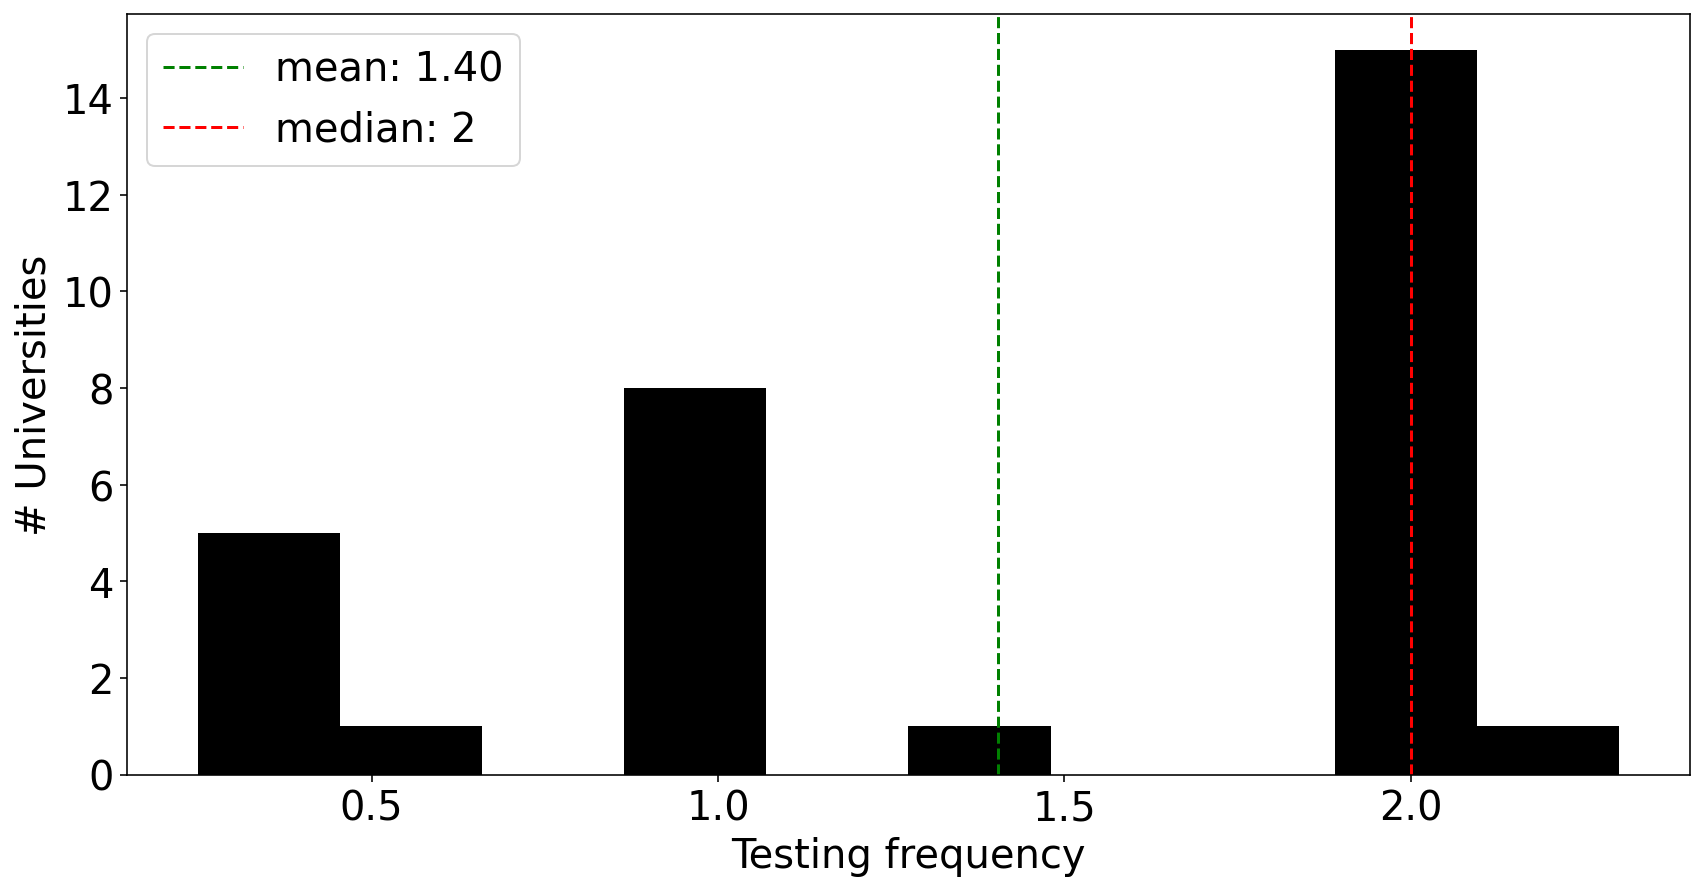

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
v = df.query("test_freq!=0").test_freq.values
x = v[~np.isnan(v)]
mean = x.mean()
median = np.median(x)
ax.hist(x, color="k")
ax.axvline(mean, label=f"mean: {mean:,.2f}", color="green", linestyle="--")
ax.axvline(median, label=f"median: {median:,.0f}", color="red", linestyle="--")
kwd = {
    "xlabel": "Testing frequency",
    "ylabel": "# Universities"
}
ax.set(**kwd)
ax.legend()

fig.show()

# Top 5 states by number of universities

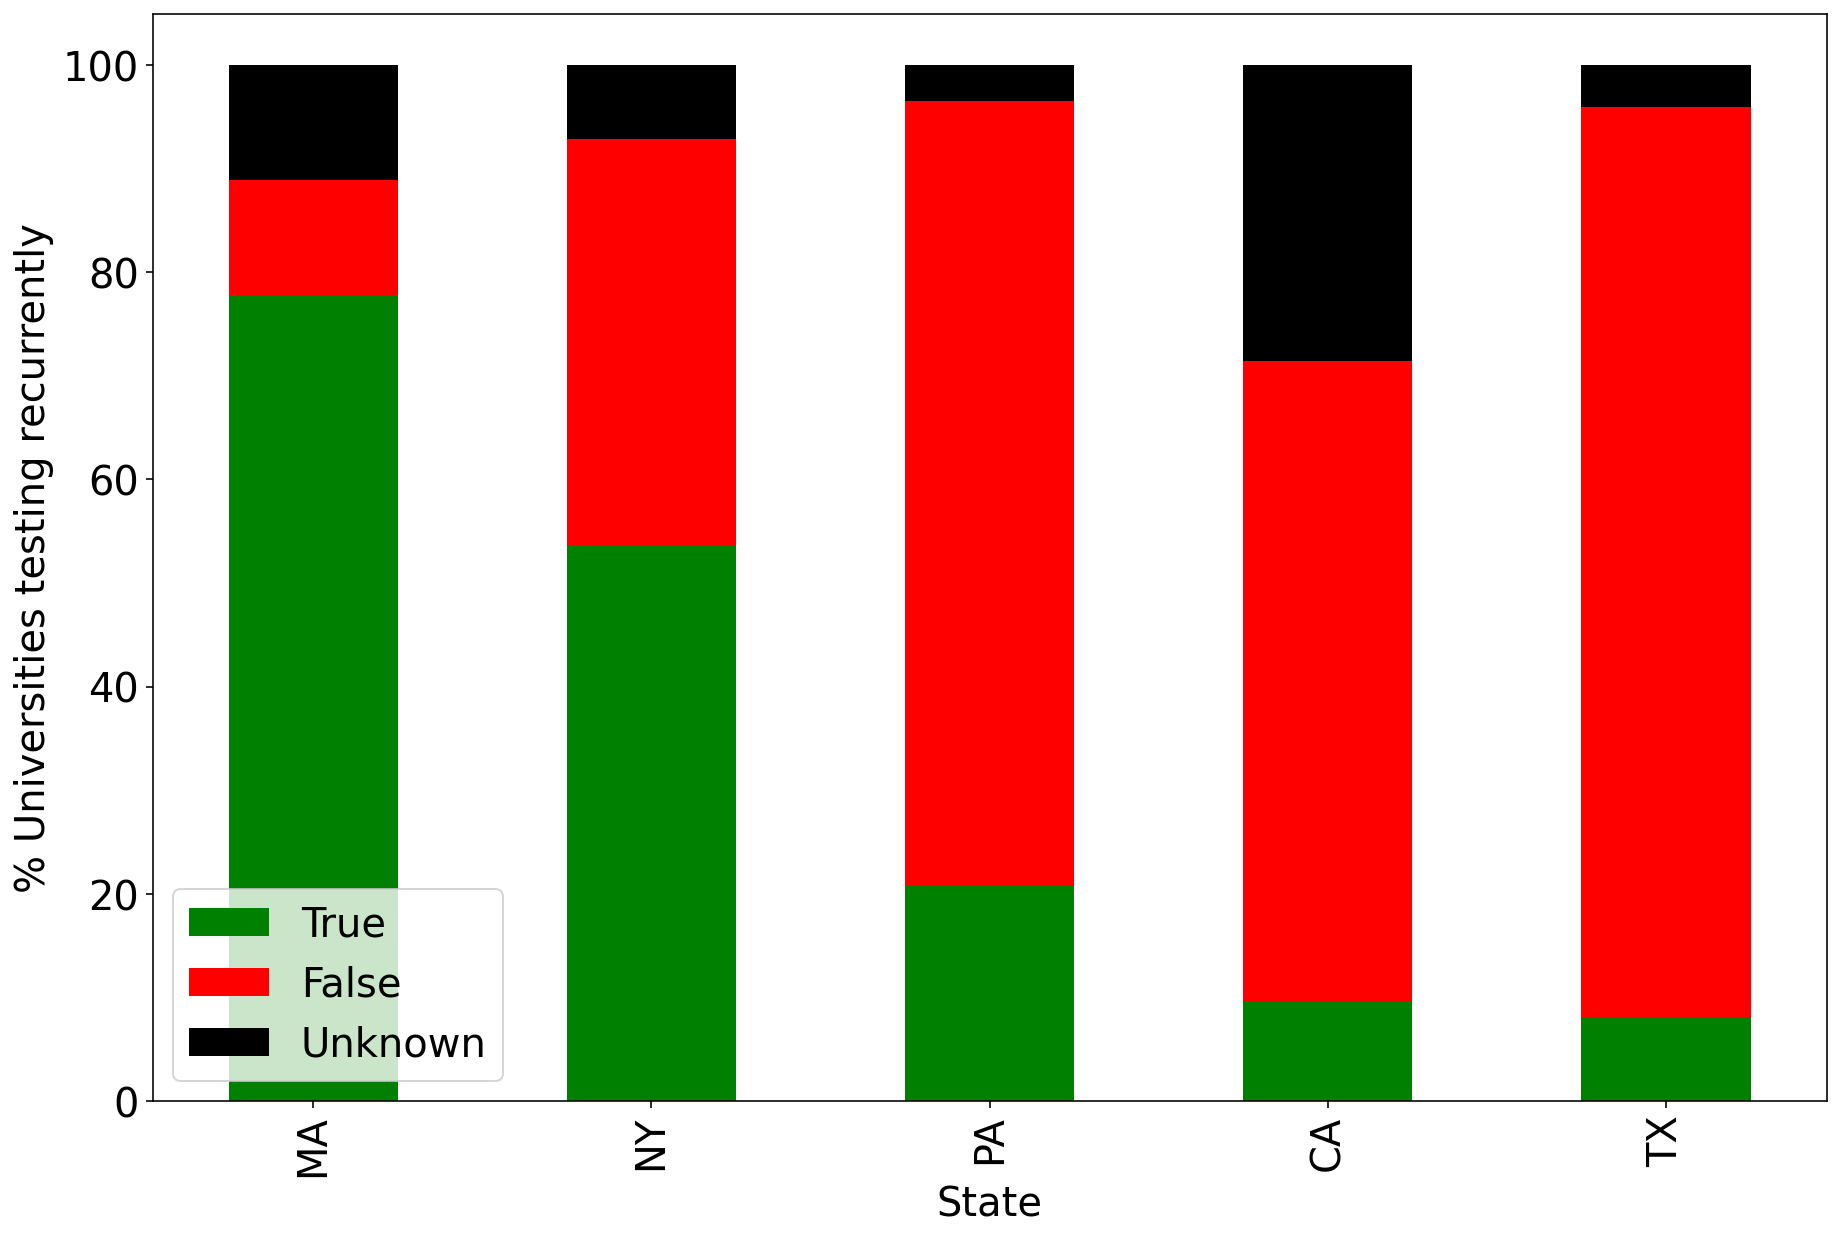

In [251]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values

#width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing initial"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

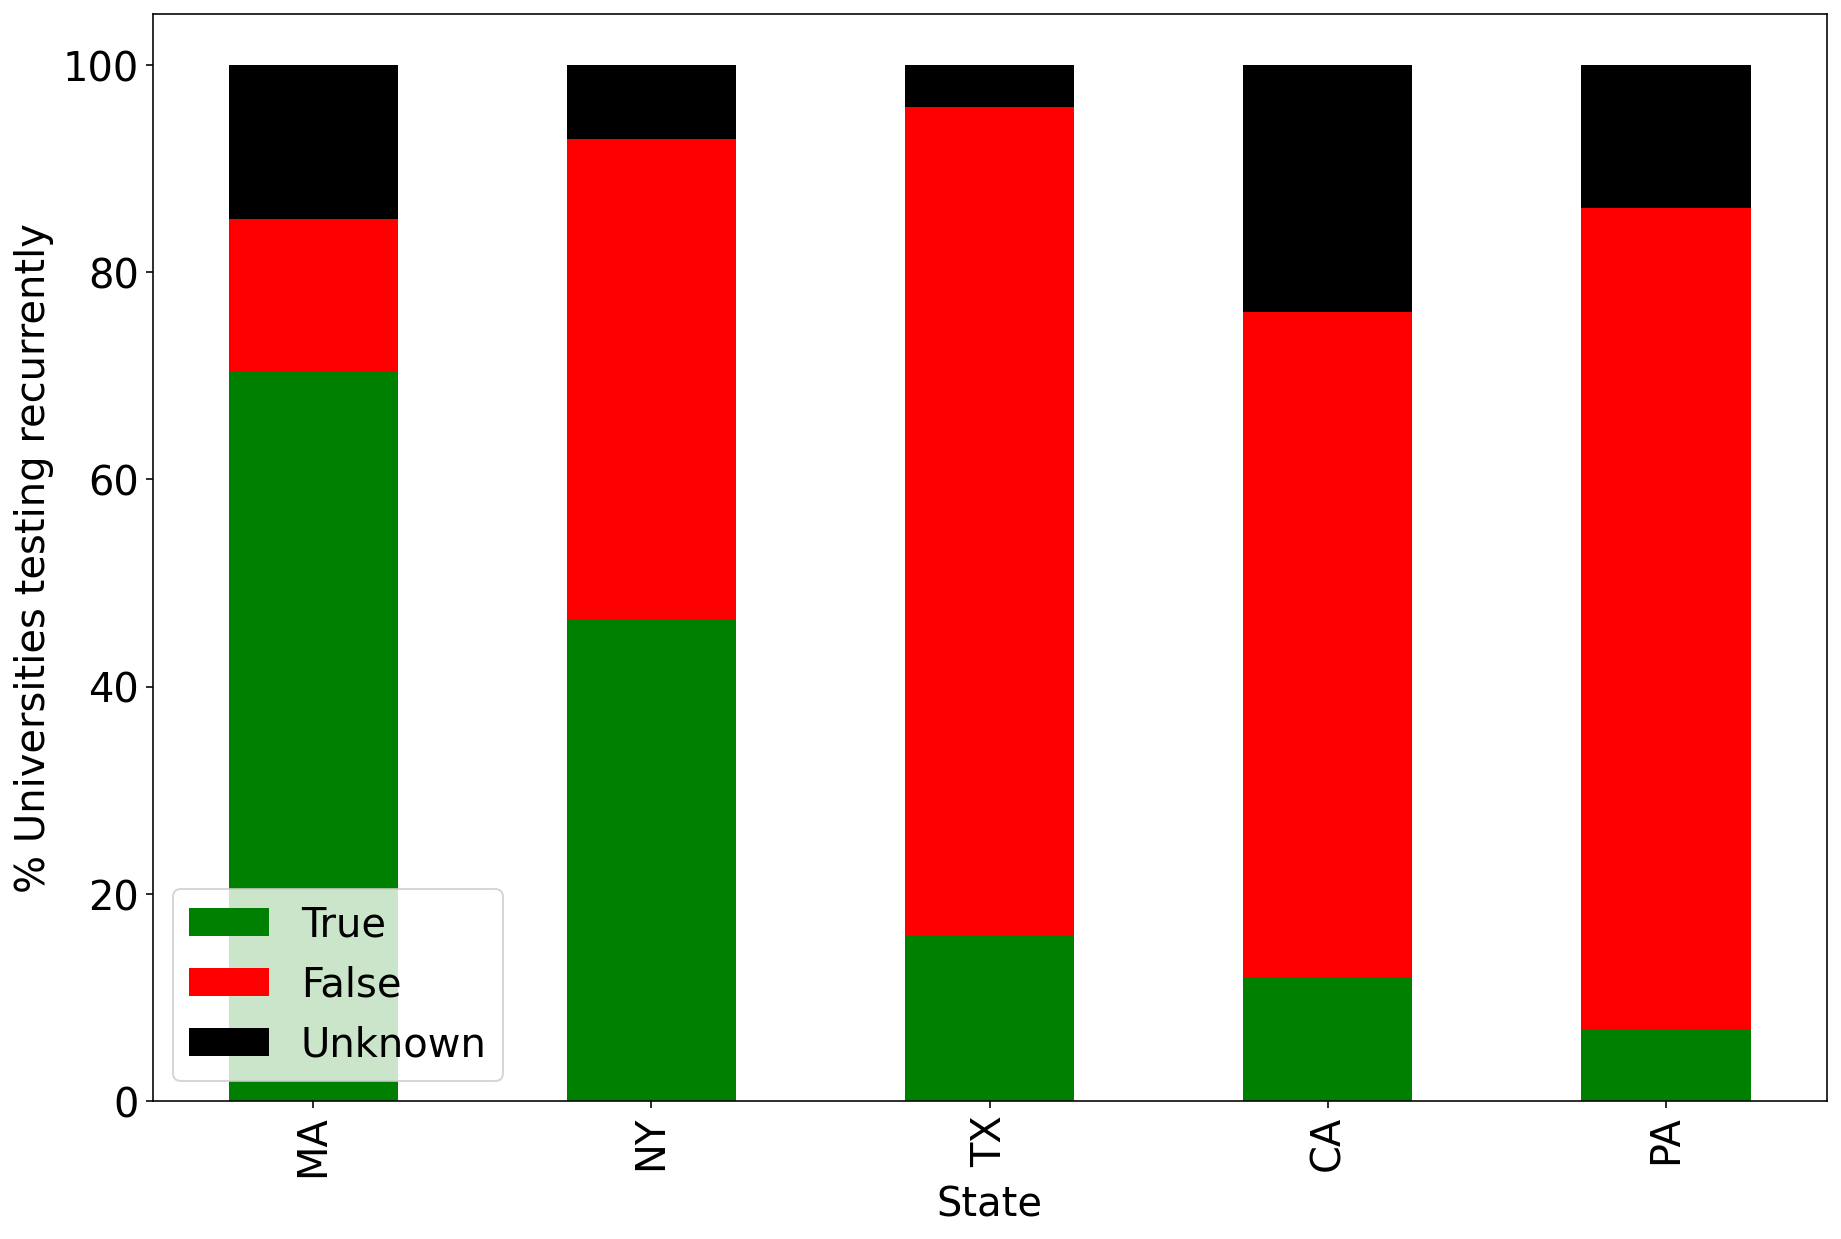

In [252]:
v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values

#width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing recurrently"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

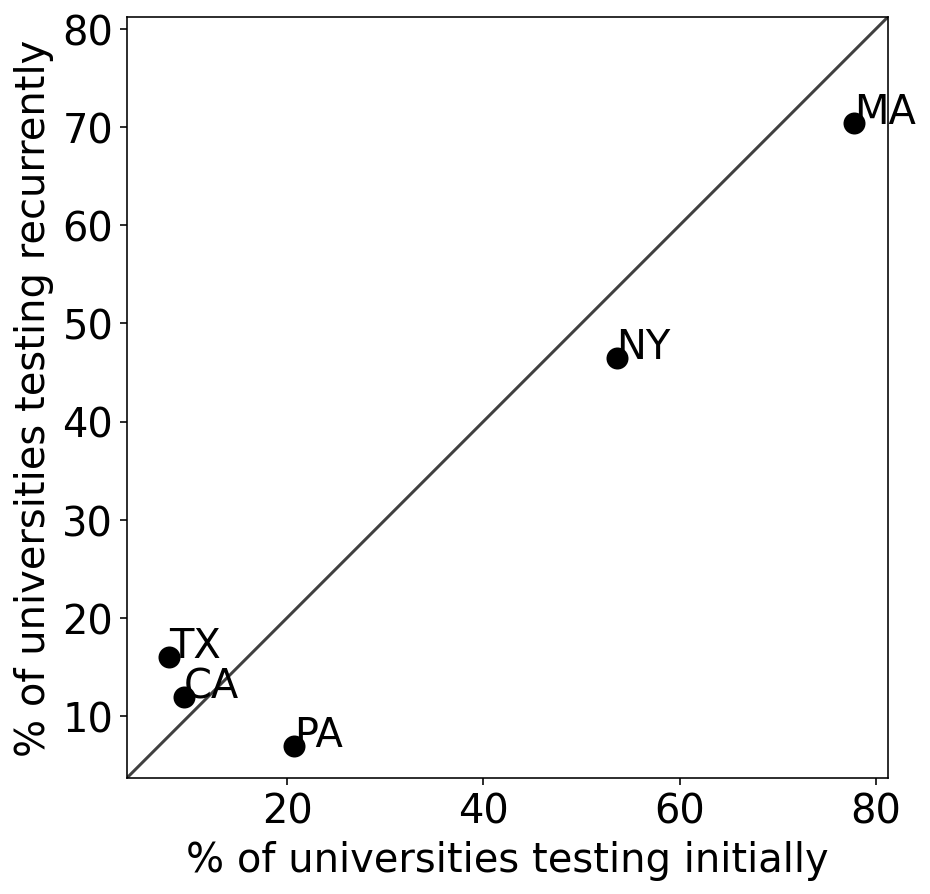

In [255]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
recurrent = v/v.values.sum(axis=1)[:,None]*100

initial = initial.loc[top_states]
recurrent = recurrent.loc[top_states]

fig, ax = plt.subplots(figsize=(7,7))

x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y, s=100, color="k")
yex(ax)
for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)

fig.show()

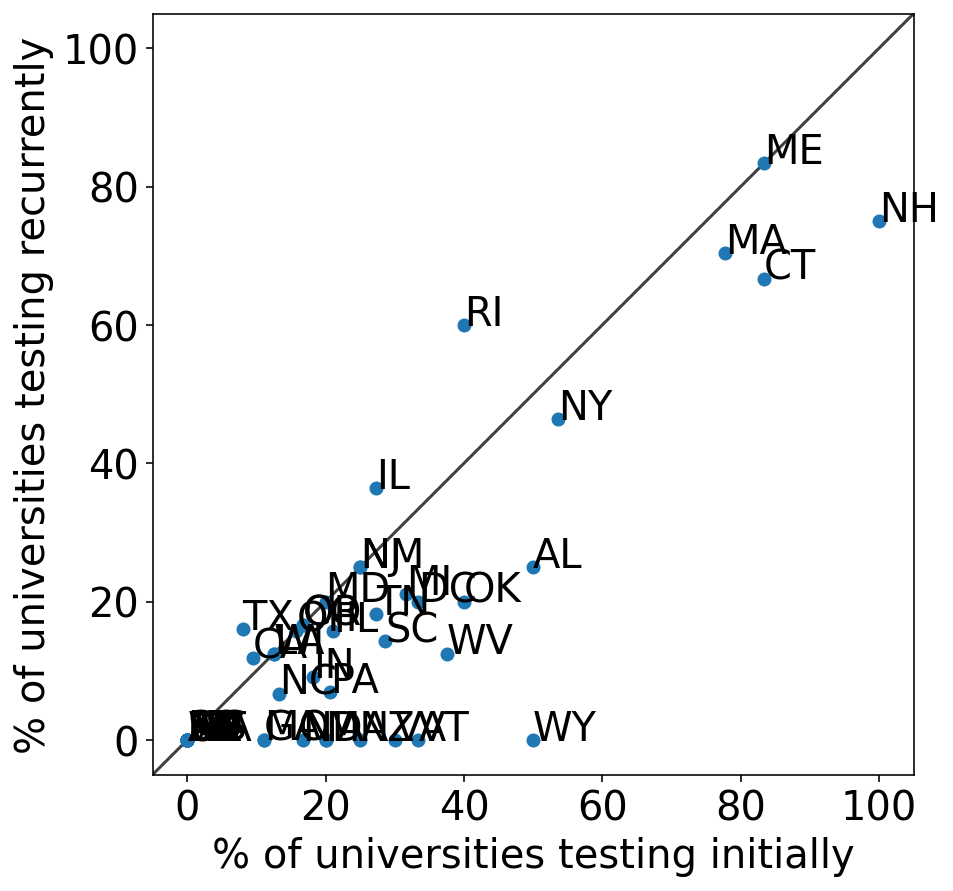

In [256]:
# all states
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0)
recurrent = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(7,7))


x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y)
yex(ax)

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)
for (xx, yy, txt) in zip(x, y, initial.index.values):
  ax.annotate(txt, (xx, yy))
fig.show()

# Positivity rate per state

In [257]:
!wget https://covidtracking.com/api/v1/states/daily.csv 

--2020-08-02 23:04:25--  https://covidtracking.com/api/v1/states/daily.csv
Resolving covidtracking.com (covidtracking.com)... 162.243.166.170, 104.248.63.231, 2604:a880:400:d0::dff:1, ...
Connecting to covidtracking.com (covidtracking.com)|162.243.166.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1849557 (1.8M) [text/csv]
Saving to: ‘daily.csv.2’

daily.csv.2         100%[===================>]   1.76M  3.21MB/s    in 0.5s    

2020-08-02 23:04:26 (3.21 MB/s) - ‘daily.csv.2’ saved [1849557/1849557]



In [258]:
daily = pd.read_csv("daily.csv")

In [259]:
gb = daily.groupby("state")[["positive", "negative"]].sum()
pos = gb["positive"]/(gb["positive"] + gb["negative"])

In [260]:
initial.index.map(pos)

Float64Index([0.011943613371203808,  0.10033725399300127,  0.07051246531771728,
               0.14991850327795642,  0.05993639764418329,  0.11598506470419201,
               0.11814297048727446,  0.11573251477169326,  0.11611338476991037,
                0.0920745216846094,  0.11049130508505597, 0.014322422598703364,
               0.10466822874872947,  0.10008210598398298,  0.10931812492602844,
               0.09266875103233115, 0.047977670757016956,  0.09743700529950346,
                0.1428311325923007,  0.13351548841438862, 0.035561272835055974,
               0.08608370268523231,  0.06617555052943341,   0.0650595155013589,
               0.10310215734566697, 0.016909921139266173,  0.07083143540148785,
               0.03624430576963657,  0.11296302895251528,  0.05432661325039984,
                0.1592026572762739, 0.037766846185354974,  0.07921329563136684,
               0.13461594729203855,  0.07450787715695553,  0.04640132326274825,
              0.039787524373773336,  0.1

# US News top universities

In [275]:
usnr = pd.read_excel("http://andyreiter.com/wp-content/uploads/2019/09/US-News-Rankings-Universities-Through-2020.xlsx", header=1)

In [276]:
np.setdiff1d(usnr["University Name"], df.institution.values)

array(['College of William and Mary', 'Georgia Institute of Technology',
       'Pennsylvania State University-University Park',
       'Rutgers University-New Brunswick',
       'Texas A&M University-College Station',
       'University of California-Berkeley',
       'University of California-Davis',
       'University of California-Irvine',
       'University of California-Los Angeles',
       'University of California-San Diego',
       'University of California-Santa Barbara', 'University of Georgia',
       'University of Illinois-Urbana-Champaign',
       'University of Michigan-Ann Arbor',
       'University of North Carolina-Chapel Hill',
       'University of Texas-Austin', 'University of Wisconsin-Madison'],
      dtype=object)

In [277]:
top_map = {
  'College of William and Mary':"College of William & Mary", 
  'Georgia Institute of Technology': "University System of Georgia — Georgia Institute of Technology",
  'Pennsylvania State University-University Park': "Pennsylvania State University",
  'Rutgers University-New Brunswick': "Rutgers University",
  'Texas A&M University-College Station': "Texas A&M University system — College Station",
  'University of California-Berkeley': "University of California at Berkeley",
  'University of California-Davis':"University of California at Davis",
  'University of California-Irvine':"University of California at Irvine",
  'University of California-Los Angeles': "University of California at Los Angeles",
  'University of California-San Diego': "University of California at San Diego",
  'University of California-Santa Barbara': "University of California at Santa Barbara", 
  'University of Georgia': "University System of Georgia — University of Georgia",
  'University of Illinois-Urbana-Champaign': "University of Illinois at Urbana-Champaign",
  'University of Michigan-Ann Arbor': "University of Michigan at Ann Arbor",
  'University of North Carolina-Chapel Hill': "University of North Carolina at Chapel Hill",
  'University of Texas-Austin':"University of Texas at Austin", 
  'University of Wisconsin-Madison': "University of Wisconsin at Madison"
}

In [278]:
usnr["University Name"] = usnr["University Name"].apply(lambda x: top_map.get(x, x))

In [281]:
top_uni = df[df.institution.isin(usnr["University Name"].values)]

In [286]:
top_uni.groupby(["rtc_model", "testing"]).size().unstack(fill_value=0)

testing,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,0,11,0
Planning for online,0,7,0
Proposing a hybrid model,1,38,2


In [287]:
top_uni.groupby(["rtc_model", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,3,6,2
Planning for online,4,3,0
Proposing a hybrid model,9,28,4


In [289]:
top_uni.groupby(["rtc_model", "test_recurring"]).size().unstack(fill_value=0)

test_recurring,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,0,1
Considering a range of scenarios,0,1,0
Planning for in-person,5,5,1
Planning for online,3,3,1
Proposing a hybrid model,13,23,5


In [292]:
v = top_uni.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,14,2,0
TRUE,6,29,4
Unknown,1,1,4


# Scraping college case data from the NYT

In [294]:
from urllib.request import urlretrieve 
from bs4 import BeautifulSoup 
from urllib.request import urlopen
import re

In [295]:

url = "https://www.nytimes.com/interactive/2020/07/28/us/covid-19-colleges-universities.html"

html= urlopen(url)
soup = BeautifulSoup(html)
#ret = soup.findAll(text=re.compile(text))

In [302]:
soup.find("div", { "id" : "schoolList" }).findAll("div", recursive=False)

[]

In [303]:
!wget https://www.nytimes.com/interactive/2020/07/28/us/covid-19-colleges-universities.html -O nyt.html

--2020-08-02 23:49:15--  https://www.nytimes.com/interactive/2020/07/28/us/covid-19-colleges-universities.html
Resolving www.nytimes.com (www.nytimes.com)... 151.101.1.164, 151.101.65.164, 151.101.129.164, ...
Connecting to www.nytimes.com (www.nytimes.com)|151.101.1.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: nyt-purr=cfshcfhssc; Expires=Mon, 02 Aug 2021 23:49:15 GMT; Path=/; Domain=.nytimes.com;SameSite: Lax;Secure at position 88.
Length: 588111 (574K) [text/html]
Saving to: ‘nyt.html’

nyt.html            100%[===================>] 574.33K  --.-KB/s    in 0.09s   

2020-08-02 23:49:15 (6.50 MB/s) - ‘nyt.html’ saved [588111/588111]



In [319]:
with open("nyt.txt", "r", encoding='utf-8') as f:
    text= f.read()

In [320]:
s = BeautifulSoup(text)

In [380]:
schoolname = []
schoolcases = []
schoolloc = []

sn = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolname"})
sc = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolcases"})
sl = s.find("div", {"id":"schoolList"}).findAll("div", {"class":"schoolloc"})
for (n, c, l) in zip(sn, sc, sl):
  name = n.text.strip()
  casenum = int(c.text.strip())
  loc = l.text.strip()
  if "*" in name:
    name = name.replace("*", "")
  if "," in name:
    name = name.replace(",", " at")
    print(name)
  schoolname.append(name)
  schoolcases.append(casenum)
  schoolloc.append(loc)

University of California at Berkeley
University of California at Los Angeles
University of California at Irvine
University of California at Davis
California State University at Long Beach
University of Nevada at Reno
University of Nevada at Las Vegas
University of Maryland at College Park
California Polytechnic State University at San Luis Obispo
University of California at Riverside
California State University at Northridge
University of Maryland at Baltimore County
University of California at Santa Cruz
California State University at East Bay
University of South Florida at St. Petersburg
University of California at Santa Barbara
California State University at Dominguez Hills
California State University at San Marcos
California State University at San Bernardino
California State Polytechnic University at Pomona
California State University at Chico
California State University at Channel Islands
University of Tennessee at Knoxville


In [376]:
cases = pd.DataFrame({"institution": schoolname, "cases":schoolcases, "location":schoolloc})

In [377]:
np.intersect1d(top_uni.institution.values, cases.institution.values).shape

(27,)

In [381]:
np.setdiff1d(top_uni.institution.values, cases.institution.values)

array(['Boston University', 'Brandeis University', 'Brown University',
       'Case Western Reserve University', 'College of William & Mary',
       'Cornell University', 'Duke University', 'Emory University',
       'George Washington University', 'Harvard University',
       'Johns Hopkins University', 'Lehigh University',
       'Massachusetts Institute of Technology', 'New York University',
       'Northeastern University', 'Pennsylvania State University',
       'Rensselaer Polytechnic Institute', 'Rutgers University',
       'Syracuse University',
       'Texas A&M University system — College Station',
       'Tufts University', 'Tulane University',
       'University System of Georgia — Georgia Institute of Technology',
       'University System of Georgia — University of Georgia',
       'University of California at San Diego',
       'University of Illinois at Urbana-Champaign',
       'University of Miami', 'University of Michigan at Ann Arbor',
       'University of Wisconsi

In [392]:
cases[cases.institution.str.contains("Mass")]

,institution,cases,location
144,University of Massachusetts Amherst,6,"Amherst, Mass."
171,University of Massachusetts Medical School,4,"Worcester, Mass."


In [341]:
top_uni

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,comments
Boston College,Boston College,Private,MA,https://www.bostonglobe.com/2020/05/19/metro/b...,Planning for in-person,7/26/2020,TRUE,Unknown,TRUE,TRUE,1.0,analyzed by The Broad Institute,Unknown,"""weekly surveillance testing"" (https://www.bc...."
Boston University,Boston University,Private,MA,https://www.bu.edu/back2bu/covid-19-testing-tr...,Proposing a hybrid model,7/28/2020,TRUE,Both asymptomatic and symptomatic,TRUE,TRUE,2.0,In house lab,NaN,NaN
Brandeis University,Brandeis University,Private,MA,https://www.brandeis.edu/fall-2020/pdfs/task-f...,Proposing a hybrid model,7/28/2020,TRUE,Asymptomatic,TRUE,TRUE,2.0,Broad Institute,NaN,"High-Frequency, Universal Testing. Brandeis wi..."
Brown University,Brown University,Private,RI,https://healthy.brown.edu/updates/planning-groups,Proposing a hybrid model,7/27/2020,TRUE,Symptomatic,TRUE,TRUE,NaN,"University Health Services conducts, Lifespan ...",Unknown,They've implemented a testing pilot over the s...
California Institute of Technology,California Institute of Technology,Private,CA,https://coronavirus.caltech.edu/fall-2020-plan,Proposing a hybrid model,7/22/2020,TRUE,Symptomatic,Unknown,FALSE,0.0,NaN,NaN,Testing at the health center is not available ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Villanova University,Villanova University,Private,PA,https://www1.villanova.edu/content/dam/villano...,Planning for in-person,8/2/2020,TRUE,Unknown,TRUE,FALSE,NaN,Quest,NaN,Testing for students only
Wake Forest University,Wake Forest University,Private,NC,https://ourwayforward.wfu.edu/2020/07/updates-...,Proposing a hybrid model,8/2/2020,TRUE,Symptomatic,TRUE,FALSE,NaN,Azova Health,NaN,"Instead of taking the at home kit test, you ca..."
Washington University in St. Louis,Washington University in St. Louis,Private,MO,https://covid19.wustl.edu/health-safety/,Proposing a hybrid model,7/30/2020,Unknown,Unknown,Unknown,Unknown,0.0,NaN,NaN,One of the most obtuse websites. But no mentio...
Worcester Polytechnic Institute,Worcester Polytechnic Institute,Private,MA,https://www.wpi.edu/we-are-wpi/academics,Proposing a hybrid model,7/28/2020,TRUE,Symptomatic,TRUE,TRUE,NaN,NaN,NaN,WPI has not released how they will test but ha...
